## **멜론 차트**에서 연도별로 상위 50곡의 **가사**를 크롤링하고, 각 곡에 대해 **감정 분석**을 수행하여 **연도별 감정 점수**를 시각화

1. **웹 크롤링**:
   - 멜론 차트에서 2018년부터 2023년까지의 **연도별 상위 50곡** 정보를 크롤링합니다.
   - 각 곡의 **곡명**, **가수**, **곡 ID**, **가사**를 추출하여 데이터를 수집합니다.
   - 곡 ID를 기반으로 **곡 상세 페이지**에 요청을 보내고, 해당 페이지에서 가사를 크롤링합니다.

2. **감정 분석**:
   - 수집한 **가사**를 기반으로, **TextBlob** 라이브러리를 사용해 **감정 점수**를 계산합니다.
   - 각 곡의 가사를 하나의 문자열로 합친 뒤 **sentiment.polarity** 값을 이용해 감정 점수를 계산하고, 이를 DataFrame에 **sentiment_score** 컬럼으로 추가합니다.

3. **연도별 평균 감정 점수 계산**:
   - 각 연도별로 감정 점수의 **평균**을 계산하고, 이를 **avg_sentiment_df**라는 DataFrame에 저장합니다.

4. **시각화**:
   - **Seaborn**과 **Matplotlib**를 사용하여 연도별 **평균 감정 점수**를 **라인 그래프**로 시각화합니다.

5. **특이사항**:
   - 2019년의 감정 점수가 상대적으로 낮은 이유는 **사재기 논란**과 관련이 있습니다. 해당 연도의 차트 상위 곡들은 대체로 **슬픈 발라드**곡들이었고, 그로 인해 감정 분석에서 **부정적인 점수**가 많이 나왔습니다.


### **1.웹 크롤링**  

멜론 사이트는 **동적 사이트**가 아닌 **정적 사이트**로, 데이터를 JSON 형태로 요청하는 것이 아니라 HTML 파일을 다시 받아오는 방식으로 정보를 업데이트합니다. 이 때문에 **BeautifulSoup**을 이용하여 HTML 데이터를 파싱하고 필요한 정보를 추출해야 합니다.




In [ ]:
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup


#### **2018년부터 2023년까지의 연도별 멜론 차트 Top 50 데이터를 가사와 함께 반복해서 크롤링**

In [ ]:
url = 'https://www.melon.com/chart/age/list.htm'
headers = {
    'User-Agent': ('Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
                   '(KHTML, like Gecko) Chrome/68.0.3440.75 Safari/537.36')
}

# 연도 리스트 (2018부터 2023까지)
years = [str(year) for year in range(2018, 2024)]



#### **About URL, header, Params**

1. **URL**:  
   `url` 변수는 멜론 차트 페이지의 주소로, 연도별 차트를 조회하는 페이지를 지정합니다.

2. **헤더**:  
   `headers`는 요청 헤더로, 웹 브라우저와 유사한 `User-Agent` 값을 사용하여 서버에서 요청을 정상적으로 처리하도록 합니다.

3. **파라미터**:  
   `params` 딕셔너리는 URL에 추가될 쿼리 파라미터를 정의합니다.  
   - `idx`: 요청하는 차트의 구분 값으로 '1'은 기본 차트를 의미합니다.  
   - `chartType`: `'YE'`는 연도별 차트를 요청한다는 뜻입니다.  
   - `chartGenre`: `'KPOP'`은 장르를 한국 가요로 설정합니다.  
   - `chartDate`: `'2023'`은 2023년 차트를 요청한다는 의미입니다.  
   - `moved`: `'Y'`는 데이터를 이동시켜 최신 순으로 정렬합니다.



---

**BeautifulSoup을 사용한 HTML 파싱**  
- `BeautifulSoup`을 사용하여 멜론 차트 페이지의 HTML을 파싱합니다.  
- `select('.lst50')`는 **.lst50** 클래스를 가진 모든 HTML 요소를 찾아 리스트로 반환합니다. 이 클래스는 Top 50 곡들의 정보를 포함하는 요소입니다.

**DataFrame 준비**  
- `columns` 리스트를 정의하여 DataFrame의 열 이름을 설정합니다.  
- `kpop_2023` DataFrame을 준비합니다. 이 DataFrame에는 각 곡의 제목(title), 가수(singer), 가사(lyric) 정보가 담길 것입니다.

**각 곡에 대한 정보 추출**  
- `for element in elements:`는 `.lst50` 클래스를 가진 각 곡에 대해 반복합니다.  
- 곡의 ID를 추출하는 부분입니다. `select('a[onclick*=SongDetail]')`를 통해 곡의 상세 페이지로 이동하는 링크를 찾고, 정규 표현식을 사용해 곡 ID를 추출합니다.  
- 추출한 곡 ID를 이용하여 곡의 상세 페이지 URL을 생성합니다.

**곡의 가사 추출**  
- `requests.get()`을 사용하여 곡의 상세 페이지로 요청을 보냅니다.  
- 곡의 가사를 포함하는 `.lyric` 클래스를 선택하고, `<br/>` 태그를 기준으로 가사를 분리합니다.  
- 가사에 불필요한 빈 항목을 제거하여 **lyrics** 리스트를 만듭니다.

**곡명과 가수 추출**  
- 곡명은 `.rank01` 클래스를 통해 추출하고, 가수는 `.rank02 > a`를 통해 추출합니다.  
- `.text.strip()`을 사용하여 불필요한 공백을 제거합니다.

**데이터 저장**  
- 추출한 곡명, 가수, 곡 ID, 가사를 하나의 딕셔너리로 저장합니다.  
- 이 딕셔너리를 `kpop_50` 리스트에 추가합니다.

In [ ]:
# 연도별 데이터프레임을 저장할 딕셔너리
dataframes = {}

# 각 연도에 대해 크롤링 진행
for year in years:
    print(f"Processing data for {year}")

    # URL 파라미터 설정
    params = {
        'idx': '1',
        'chartType': 'YE',  # 10년 단위로 검색하는 부분과 연관
        'chartGenre': 'KPOP',  # 가요검색: KPOP
        'chartDate': year,   # 검색연도
        'moved': 'Y',
    }

    # 요청 보내고 BeautifulSoup로 파싱
    response = requests.get(url, params=params, headers=headers)
    dom_list = BeautifulSoup(response.text, 'html.parser')
    elements = dom_list.select('.lst50')  # lst50 클래스를 가진 element 전부를 List로 리턴

    # 각 연도에 대한 데이터프레임 초기화
    kpop_data = []

    # 각 곡에 대해 데이터 수집
    for element in elements:
        # 곡 ID 추출
        song_id_html = str(element.select('a[onclick*=SongDetail]'))
        matched = re.search(r"\'(\d+)\'", song_id_html)
        song_id = matched.group(1) if matched else None
        song_url = f'https://www.melon.com/song/detail.htm?songId={song_id}'

        # 곡 정보 페이지로 요청하여 가사 추출
        song_response = requests.get(song_url, headers=headers)
        song_soup = BeautifulSoup(song_response.text, 'html.parser')

        lyric = song_soup.select('.lyric')[0]
        lyrics = str(lyric).split('<br/>')[1:-1]
        lyrics = [i for i in lyrics if i ]

        # 곡명, 아티스트 추출
        song_name = element.select_one('.rank01').text.strip()
        singer = element.select_one('.rank02 > a').text.strip()

        # 데이터 저장
        data = {
            'song_name': song_name,
            'singer': singer,
            'song_id': song_id,
            'lyrics': lyrics
        }
        kpop_data.append(data)

    print(f"Number of items collected for {year}: {len(kpop_data)}")

    # 각 연도에 대한 DataFrame 생성
    df = pd.DataFrame(kpop_data)

    # 딕셔너리에 연도별 DataFrame 저장
    dataframes[year] = df

    # 각 연도의 데이터프레임 확인
    print(f"Data for {year} collected:")
    print(df.head())
    print(f"Shape of {year} data: {df.shape}\n")

Processing data for 2018
Number of items collected for 2018: 50
Data for 2018 collected:
                               song_name           singer   song_id  \
0                 사랑을 했다 (LOVE SCENARIO)             iKON  30859584   
1                                   그날처럼              장덕철  30755375   
2  모든 날, 모든 순간 (Every day, Every Moment)               폴킴  30962526   
3                                   지나오다         닐로(Nilo)  30699142   
4                                     뿜뿜  모모랜드 (MOMOLAND)  30816860   

                                              lyrics  
0  [지우지 못할 추억이 됐다 , 볼만한 멜로드라마 , 괜찮은 결말 , 그거면 됐다 널...  
1  [넌 어떻게 사는지 참 궁금해, 날 걱정하는 사람들에게, 다 잊었단 거짓말하는 내가...  
2  [생각만 해도 눈물이나, 힘든 시간 날 지켜준 사람, 이제는 내가 그댈 지킬 테니,...  
3  [여전히 내 하루는 온통 네 생각에, 뜬 눈으로 밤을 지새고, 난 두려워 시간이 쌓...  
4  [랑데뷰, 내 마음을 들었다 놨다 해 맘대루 , 맘대루, 지금 내 눈엔 눈엔 눈엔,...  
Shape of 2018 data: (50, 4)

Processing data for 2019
Number of items collected for 2019: 50
Data for 2019 collected:
                                   s

In [ ]:
print(f"Number of items in dataframes: {len(dataframes)}")


Number of items in dataframes: 6


## **감정분석**

**각 연도의 곡 가사에 대해 감정 분석을 수행하고, 감정 점수를 계산하여 각 DataFrame에 추가  

각 가사의 감정 점수는 `TextBlob`을 사용해 계산되며, 결과는 `'sentiment_score'` 컬럼에 저장됩니다.**

In [ ]:
from textblob import TextBlob

# 각 연도에 대해 이미 존재하는 dataframes에서 감정 분석 수행
for year, df in dataframes.items():
    print(f"Processing sentiment analysis for {year}")

    # 가사 컬럼이 비어있지 않은 경우에만 분석
    if 'lyrics' in df.columns:
        sentiment_scores = []

        # 각 곡에 대해 감정 분석
        for lyrics in df['lyrics']:
            lyric_text = ' '.join(lyrics)  # 가사를 하나의 문자열로 합침
            blob = TextBlob(lyric_text)
            sentiment_score = blob.sentiment.polarity  # 감정 점수 (polarity 값)
            sentiment_scores.append(sentiment_score)

        # 감정 점수 컬럼 추가
        df['sentiment_score'] = sentiment_scores
        dataframes[year] = df  # 딕셔너리에 업데이트

        # 결과 출력
        print(f"Sentiment analysis complete for {year}")
        print(df[['song_name', 'sentiment_score']].head())
        print(f"Shape of {year} data after adding sentiment score: {df.shape}\n")

# 모든 연도의 감정 분석 결과 출력
for year, df in dataframes.items():
    print(f"\n{year} DataFrame with sentiment scores:")
    print(df[['song_name', 'sentiment_score']].head())


Processing sentiment analysis for 2018
Sentiment analysis complete for 2018
                               song_name  sentiment_score
0                 사랑을 했다 (LOVE SCENARIO)         0.500000
1                                   그날처럼         0.000000
2  모든 날, 모든 순간 (Every day, Every Moment)         0.000000
3                                   지나오다         0.000000
4                                     뿜뿜         0.233333
Shape of 2018 data after adding sentiment score: (50, 5)

Processing sentiment analysis for 2019
Sentiment analysis complete for 2019
                                   song_name  sentiment_score
0                  사랑에 연습이 있었다면 (Prod. 2soo)         0.000000
1                                    그때가 좋았어         0.000000
2  작은 것들을 위한 시 (Boy With Luv) (Feat. Halsey)         0.435952
3                                       넘쳐흘러         0.000000
4      모든 날, 모든 순간 (Every day, Every Moment)         0.000000
Shape of 2019 data after adding sentiment score: (50, 5)

Processing s

### **각 연도별로 감정 점수의 평균을 계산하여 데이터프레임으로 저장**

In [ ]:
# 각 연도별 감정 점수 평균을 구할 리스트
avg_sentiment_scores = []

# 각 연도의 DataFrame에서 평균 감정 점수 계산
for year, df in dataframes.items():
    avg_score = df['sentiment_score'].mean()  # 감정 점수 평균 계산
    avg_sentiment_scores.append((year, avg_score))

# DataFrame으로 변환
avg_sentiment_df = pd.DataFrame(avg_sentiment_scores, columns=['Year', 'Average Sentiment'])


**각 연도별 감정점수의 평균**

In [ ]:
# 평균 감정 점수 출력
print(avg_sentiment_df)

   Year  Average Sentiment
0  2018           0.123921
1  2019           0.072234
2  2020           0.118092
3  2021           0.108588
4  2022           0.112324
5  2023           0.126747


In [ ]:
# CSV 파일로 저장
avg_sentiment_df.to_csv('avg_sentiment_by_year.csv', index=False)

## **시각화**

**연도별 평균 감정 점수(Average Sentiment Score)**를 나타내는 **선 그래프(Line Plot)입니다.**


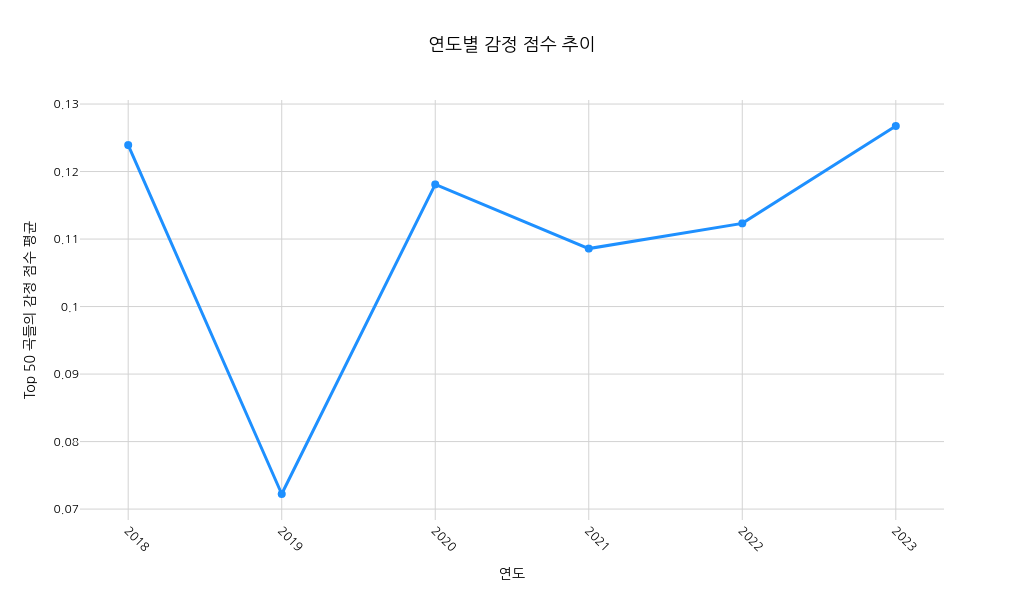

In [5]:
import plotly.graph_objects as go

# 시각화 (Line Plot)
fig = go.Figure()

# Line Plot 추가
fig.add_trace(go.Scatter(
    x=avg_sentiment_df['Year'],
    y=avg_sentiment_df['Average Sentiment'],
    mode='lines+markers',
    line=dict(color='dodgerblue', width=3),
    marker=dict(color='dodgerblue', size=8)
))

# 그래프 제목과 레이블 설정
fig.update_layout(
    title='연도별 감정 점수 추이',
    xaxis_title='연도',
    yaxis_title='Top 50 곡들의 감정 점수 평균',
    title_font_size=18,
    title_font=dict(family="NanumGothic", size=18, color="black"),
    title_x=0.5,
    xaxis_tickangle=45,
    font=dict(family="NanumGothic", size=12, color="black"),
    plot_bgcolor="white",
    paper_bgcolor="white",
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
    showlegend=False,  # 범례 제거
    width=1024,
    height=600
)

fig.show(renderer="png")


### 2019년의 감정 점수가 낮았던 이유는 **사재기 논란**과 관련이 있다고 예상합니다. 사재기 의혹을 받았던 곡들은 대부분 **슬픈 발라드**곡들이었는데, 이 곡들은 감정적으로 **부정적인 감정**을 표현하기 때문에 감정 분석에서 **낮은 점수**를 받았습니다. 슬픈 발라드곡들은 **슬픔, 아픔, 이별** 등의 감정을 다루기 때문에, 그로 인해 **감정 점수**가 낮게 나오는 경향이 있었습니다. 따라서, 2019년 차트 상위권에 있던 사재기 곡들이 주로 슬픈 발라드였기 때문에 감정 점수가 낮았다고 예상합니다.